#### **Objective**

For this challenge, you will be predicting a full year worth of sales for three items at two stores located in three different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. The dataset is small enough to allow you to try numerous different modeling approaches.



In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [2]:
# Loading the data

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [3]:
# Seeing the data
train

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


In [4]:
test

,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat
...,...,...,...,...,...
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat


In [5]:
sample

,row_id,num_sold
0,26298,100
1,26299,100
2,26300,100
3,26301,100
4,26302,100
...,...,...
6565,32863,100
6566,32864,100
6567,32865,100
6568,32866,100


#### Inital Checks

In [6]:
# Checking the shape of train and test

print("The shape of train set is",train.shape)
print("The shape of test data is", test.shape)

The shape of train set is (26298, 6)
The shape of test data is (6570, 5)


In [7]:
# Checking the columns we have in both train and test data

print("The columns we have in our train data is:\n", train.columns.to_list())
print("The columns we have in our test data is:\n", test.columns.to_list())


The columns we have in our train data is:
 ['row_id', 'date', 'country', 'store', 'product', 'num_sold']
The columns we have in our test data is:
 ['row_id', 'date', 'country', 'store', 'product']


So num_sold is our target column and we have to predict that

In [8]:
# Checking the data types of our train and test data

train.dtypes

row_id       int64
date        object
country     object
store       object
product     object
num_sold     int64
dtype: object

In [9]:
test.dtypes

row_id      int64
date       object
country    object
store      object
product    object
dtype: object

In [10]:
# "date" column in both train and test data is in object, lets convert it to date-time format

train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])

In [11]:
# Checking if the changes took place

train.dtypes

row_id               int64
date        datetime64[ns]
country             object
store               object
product             object
num_sold             int64
dtype: object

In [12]:
test.dtypes

row_id              int64
date       datetime64[ns]
country            object
store              object
product            object
dtype: object

In [13]:
# Lets check for missing values

print("The no of missing values in train data\n", train.isna().sum())
print("The number of missing values for test data\n", test.isna().sum())

The no of missing values in train data
 row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64
The number of missing values for test data
 row_id     0
date       0
country    0
store      0
product    0
dtype: int64


- Thats a good thing we dont have any missing values in our data

In [14]:
# Checking the summary of the data we got

train.describe(include='O')

,country,store,product
count,26298,26298,26298
unique,3,2,3
top,Finland,KaggleMart,Kaggle Mug
freq,8766,13149,8766


- we have 3 different item,2 different stores and 3 different countries.
- The top country is Finland, top_store id KaggleMart and top product is KaggleMug 

In [15]:
train.describe()

,row_id,num_sold
count,26298.000000,26298.000000
mean,13148.500000,387.533577
std,7591.723026,266.076193
min,0.000000,70.000000
25%,6574.250000,190.000000
50%,13148.500000,315.000000
75%,19722.750000,510.000000
max,26297.000000,2884.000000


- For **50%** of the items, the no. of **units sold is 315**.
- The **average** units of product sold is **387 units**
- However **the maximum** amount sold is **2884**, which is quite high. 

#### Data Exploration - Time to gain some insights!!

In [16]:
# Lets check the product for which the maximum no of quantities were sold

train[train["num_sold"] == 2884] 

,row_id,date,country,store,product,num_sold
26254,26254,2018-12-29,Norway,KaggleRama,Kaggle Hat,2884


- **Highest no.** of products sold is **"Kaggle Hat"** from the store **KaggleRama in Norway**

In [17]:
# Lets also check the minimum no of quantities sold

train[train["num_sold"] == 70]

,row_id,date,country,store,product,num_sold
4664,4664,2015-09-17,Finland,KaggleMart,Kaggle Sticker,70


- **Minimum product** sold were of **Kaggle Sticker from KaggleMart,Finland**

In [18]:
# Lets see other products from KaggleRama

train.groupby(by = ["store"])["product"].unique()

store
KaggleMart    [Kaggle Mug, Kaggle Hat, Kaggle Sticker]
KaggleRama    [Kaggle Mug, Kaggle Hat, Kaggle Sticker]
Name: product, dtype: object

- Both the shops Kaggle Mart and Kaggle Rama deals - Kaggle Mug, Kaggle Hat, Kaggle Sticker

<AxesSubplot:>

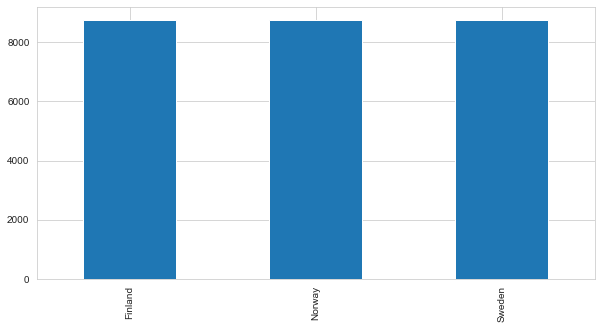

In [19]:
plt.figure(figsize = (10,5))
train["country"].value_counts().plot(kind="bar")

<AxesSubplot:>

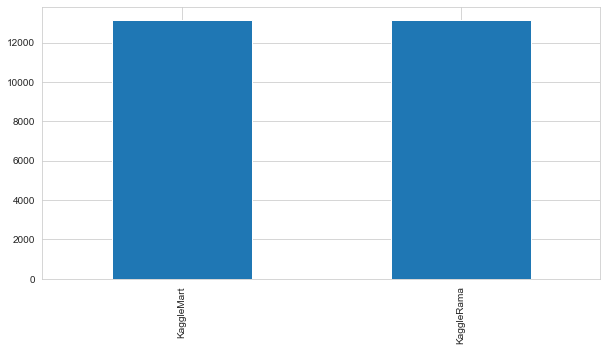

In [20]:
plt.figure(figsize=(10,5))
train["store"].value_counts().plot(kind = "bar")

<AxesSubplot:>

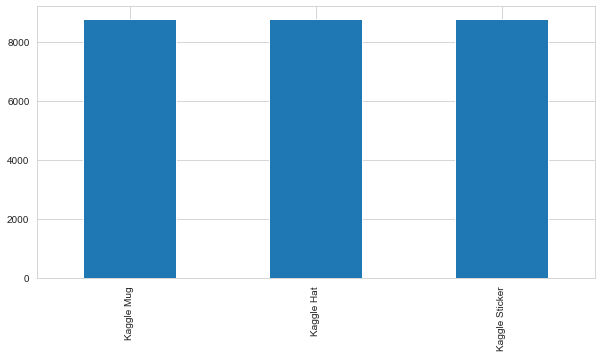

In [21]:
plt.figure(figsize=(10,5))
train["product"].value_counts().plot(kind = "bar")

- Looks like the dataset is balanced overall

In [22]:
train

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
...,...,...,...,...,...,...
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441


<AxesSubplot:>

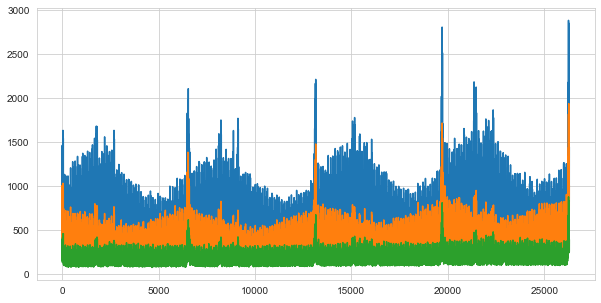

In [23]:
# Lets check if Kaggle Hats were sold the highest all this time??

plt.figure(figsize=(10,5))
train[train["product"] == "Kaggle Hat"]["num_sold"].plot(kind = "line")
train[train["product"] == "Kaggle Mug"]["num_sold"].plot(kind = "line")
train[train["product"] == "Kaggle Sticker"]["num_sold"].plot(kind = "line")


**Insights**
- The plot shows that **kaggle hats** are sold high in numbers always than any other products.
- **Maximum kaggle hats sold were approximately 2900** which is around **3x times than kaggle stickers**.
- **Kaggle stickers** were sold the **least** in comparision to the other two, maximum kaggle stickers sold were 900


In [24]:
# Lets see which country sold the highest number pf products

train.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [25]:
# Grouping the products by country

data_country = train.groupby(["country","product"]).sum().reset_index()

In [26]:
# calculating the total products we have of each category
#  
total_hats = train[train["product"] == "Kaggle Hat"]["num_sold"].sum()
total_mugs = train[train["product"] == "Kaggle Mug"]["num_sold"].sum()
total_stickers = train[train["product"] == "Kaggle Sticker"]["num_sold"].sum()

In [27]:
data_country["percentage"] = 0

In [28]:
# Creating a new column for percentage of products we have

data_country["percentage"] = np.where(data_country["product"] == "Kaggle Hat", round((data_country["num_sold"]/total_hats)*100,2),
                             np.where(data_country["product"] == "Kaggle Mug", round((data_country["num_sold"]/total_mugs)*100,2),
                             np.where(data_country["product"] == "Kaggle Sticker", round((data_country["num_sold"]/total_stickers)*100,2), 
                             data_country["percentage"] )))

In [29]:
data_country.drop(columns=["row_id"], inplace = True)

In [30]:
# Lets plot the percentages and see if we can get any insights - Its an interactive graph drawn by Plotly wont be visible in github

fig = px.bar(data_country, x = "country", y='percentage', color='product', text = 'percentage')
fig.update_layout(
    autosize=False,
    width=600,
    height=400,)
fig.show()

**Insights**
- **Norway** sold the **highest** no of all the three product, almost **43%** of the total of all the products has been sold by Norway
- **Sweden** accounts for **30.5%** of sale for all the three products
- However **Finland** accounts for **only 26%**

In [31]:
# Lets see which store sold the highest number pf products

data_store = train.groupby(["store","product"]).sum().reset_index()


In [32]:
data_store.drop(columns=["row_id"],inplace= True)

In [33]:
data_store

,store,product,num_sold
0,KaggleMart,Kaggle Hat,2010832
1,KaggleMart,Kaggle Mug,1131480
2,KaggleMart,Kaggle Sticker,573056
3,KaggleRama,Kaggle Hat,3501633
4,KaggleRama,Kaggle Mug,1974807
5,KaggleRama,Kaggle Sticker,999550


In [34]:
data_store["percentage"] = 0

In [35]:
# Finding percentage of the total hats , mugs and sticker contributed by each store


data_store["percentage"] = np.where(data_store["product"] == "Kaggle Hat", round((data_store["num_sold"]/total_hats)*100,2),
                             np.where(data_store["product"] == "Kaggle Mug", round((data_store["num_sold"]/total_mugs)*100,2),
                             np.where(data_store["product"] == "Kaggle Sticker", round((data_store["num_sold"]/total_stickers)*100,2), 
                             data_store["percentage"] )))


In [36]:
data_store

,store,product,num_sold,percentage
0,KaggleMart,Kaggle Hat,2010832,36.48
1,KaggleMart,Kaggle Mug,1131480,36.43
2,KaggleMart,Kaggle Sticker,573056,36.44
3,KaggleRama,Kaggle Hat,3501633,63.52
4,KaggleRama,Kaggle Mug,1974807,63.57
5,KaggleRama,Kaggle Sticker,999550,63.56


In [37]:
# Lets make an interactive chart to see who contributed more

plt.figure(figsize=(10,5))
fig = px.bar(data_store, x= "store", y = "percentage", color = "product", text = "percentage")
fig.update_layout(autosize=False,width=600,height=400,)

<Figure size 720x360 with 0 Axes>

**Insights**
- **KaggleRama shows a high percentage** in all of the three products than KaggleMart
- **KaggleRama** account for **63.5%** of total hats, mugs and stickers
- However **KaggleMart** store accounts for **36.4%**

In [38]:
train.date.value_counts()

2015-01-01    18
2017-09-09    18
2017-09-07    18
2017-09-06    18
2017-09-05    18
              ..
2016-04-30    18
2016-04-29    18
2016-04-28    18
2016-04-27    18
2018-12-31    18
Name: date, Length: 1461, dtype: int64

In [39]:
rowid = train["row_id"]

In [40]:
train.drop(columns=["row_id"], inplace=True)

In [41]:
train.columns

Index(['date', 'country', 'store', 'product', 'num_sold'], dtype='object')

#### Model Selection and training

In [42]:
# Splitting the train test

X = train[['date', 'country', 'store', 'product']]
y = train['num_sold']

In [43]:
print(X.shape)
print(y.shape)

(26298, 4)
(26298,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.shape)

(21038, 4)
(5260, 4)
(5260,)
(21038,)


In [46]:
X_train.head()

,date,country,store,product
20065,2018-01-19,Sweden,KaggleMart,Kaggle Hat
13611,2017-01-26,Finland,KaggleRama,Kaggle Mug
21322,2018-03-30,Norway,KaggleRama,Kaggle Hat
13835,2017-02-07,Norway,KaggleRama,Kaggle Sticker
15830,2017-05-29,Norway,KaggleMart,Kaggle Sticker


In [47]:
transformer = ColumnTransformer(transformers=[('tnf1',OneHotEncoder(sparse=False, drop='first'),['country','store','product'])])

In [48]:
x_train_transformed = transformer.fit_transform(X_train)
x_test_transformed = transformer.transform(X_test)

#### Linear Regression Model


In [49]:

lr_regressor = LinearRegression()
lr_regressor.fit(x_train_transformed,y_train)


LinearRegression()

In [50]:
# Predict the value of x_test

y_predict_lr = lr_regressor.predict(x_test_transformed)

In [51]:
y_actual = y_test

In [52]:
# Scores of linear model

r2 = (r2_score(y_actual, y_predict_lr))*100
print("The score of lr model is",r2)

The score of lr model is 74.07570531388362


In [53]:
a = X
b = y
a_train = transformer.fit_transform(a)
cv = np.mean(cross_val_score(lr_regressor, a_train, y, scoring = "r2", cv = 10))*100
print("The cross validation score is",cv)

The cross validation score is 71.05393399341521


#### Decision Tree Regressor Model

In [54]:
dt_regressor = DecisionTreeRegressor(max_depth=5)
dt_regressor.fit(x_train_transformed,y_train)

DecisionTreeRegressor(max_depth=5)

In [55]:
# predict the values

y_predict_dt = dt_regressor.predict(x_test_transformed)

In [56]:
dt_score = (r2_score(y_actual, y_predict_dt))*100
print("The decision tree score is", dt_score)

The decision tree score is 80.87594340801742


In [57]:
cv_dt = np.mean(cross_val_score(dt_regressor, a_train, y,scoring = "r2", cv = 10))*100
print("The cross val score for decision tree is",cv_dt)

The cross val score for decision tree is 77.61859720746274


In [58]:
models = {'Name':["Linear_Regression", "Decision_Tree"]
          , 'Scores':[r2,dt_score]
          , "cross_val_score":[cv, cv_dt]}

In [59]:
df = pd.DataFrame(models)
df

,Name,Scores,cross_val_score
0,Linear_Regression,74.075705,71.053934
1,Decision_Tree,80.875943,77.618597


In [612]:
y_test = test
y_test.drop(columns=["row_id"],inplace=True)
y_test = transformer.transform(y_test)

In [613]:
y_test

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 1., 1., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 1.]])

In [617]:
# predicting the test scores using decisiontree

y_prediction = dt_regressor.predict(y_test)

In [628]:
vals = {"row_id":test_row_id, "num_sold":y_prediction}

In [639]:
final_submission = pd.DataFrame(vals)

In [640]:
final_submission["num_sold"] = np.floor(final_submission["num_sold"])

In [643]:
final_submission["num_sold"] = final_submission["num_sold"].astype("int64")

In [653]:
final_submission.to_csv("data",index=False)

In [75]:
# Training the model with the whole dataset I have

features = train.iloc[:,0:4]
target = train.num_sold

In [79]:
features = transformer.fit_transform(features)

In [83]:
target = target.values

In [84]:
model = dt_regressor.fit(features, target)


In [90]:
y_test = transformer.transform(test)

In [91]:
y_test

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 1., 1., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 1., 0., 1.]])

In [92]:
number_sold = model.predict(y_test)

In [96]:
number_sold = np.floor(number_sold).astype("int64")

In [102]:
row_id = test.row_id

In [105]:
row_id = row_id.values

In [106]:
vals = {"row_id":row_id,"num_sold":number_sold}

In [111]:
df = pd.DataFrame(vals)

In [113]:
df.to_csv("Final_submission.csv", index = False)